<a href="https://colab.research.google.com/github/AnIsAsPe/Estimacion-probabilidad-conflicto-en-trayectorias-de-vuelos-paralelos/blob/main/Notebooks/Estimaci%C3%B3n_probabilidad_de_conflicto_en_trayectorias_de_vuelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import scipy.linalg
import math
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Funciones

**covarianza_a()**

$\mathbb{Cov}(error_{a,t},~error_{a,s}) = r_a^2t^2$


In [2]:
# COVARIANZA ALONG TRACK
def covarianza_a(r_a):  
      cov_a = pd.DataFrame(np.zeros((21,21)), index=range(21), columns=range(21))
      for s in range(21):
          for t in range(1,s):
                cov_a.loc[t,s]=cov_a.loc[s,t]=(r_a**2)*((t)**2)
      return cov_a

**covarianza_c()**

$\mathbb{Cov}(error_{c,t},~error_{c,s}) = \sigma_c^2(1-e^{-2\frac{r_c}{\sigma_c}vt})e^{-\frac{r_c}{\sigma_c}v(s-t)}$

In [3]:
# COVARIANZA CROSS TRACK

def covarianza_c(sigma_c, r_c, v ):
      cov_c = pd.DataFrame(np.zeros((21,21)), index=range(21), columns=range(21)) 
      for s in range(21):
          cov_c.loc[s,s] = (sigma_c**2) * (1-np.exp(-2 * r_c * v * (s) /sigma_c))
          for t in range(1,s):
              cov_c.loc[t,s] = cov_c.loc[s,t] = (sigma_c**2)*(1-np.exp(-2*r_c*v*(t)/sigma_c))*np.exp(-r_c*v*(s-t)/sigma_c)
      return cov_c

**simulacion_error()**

In [4]:
def simulacion_error(matriz_covarianza, n_simulaciones = 1):
  error = pd.DataFrame(np.random.multivariate_normal(np.zeros(len(matriz_covarianza)), 
                                                       matriz_covarianza, 
                                                       size = n_simulaciones), 
                              index =['simulación_'+str(a) for a in range(1, n_simulaciones+1)], 
                              columns=['min_' + str(t) for t in range(21)]) 
  return error

**probabilidad_de_conflicto**

In [5]:
def probabilidad_de_conflicto(velocidad, distancia, r_a, r_c, sigma_c, n_simulaciones):

    # CÁLCULO DE COVARIANZAS
    cov_c = covarianza_c(sigma_c, r_c, velocidad)
    cov_a = covarianza_a(r_a)

    X_a = {}    # diccionario para guardar las cordenadas Along-Track de cada aeronave
    X_c = {}    # diccionario para guardar las coordenadas Cross-Track de cada aeronave

    for aeronave, signo_posicion in zip(['A','B'], (1,-1)):

        # SIMULACIÖN DE LOS ERRORES

        error_c = simulacion_error(cov_c, n_simulaciones)
        error_a = simulacion_error(cov_a, n_simulaciones)

        # CÁLCULO DE LAS COORDENADAS Along-Track (X_a = v_por_t + error)

        # Obtenemos v * t para cada t
        v_por_t = pd.Series( velocidad * np.arange(21), 
                            index=['min_' + str(t) for t in range(21)])
    
        X_a[aeronave] = v_por_t + error_a

        # CÁLCULO DE COORDENADAS Cross-Track(

        X_c[aeronave] = error_c +( distancia/2 * signo_posicion)

    # PROBABILIDAD DE CONFLICTO
    a = 0.1
    Z = np.min((X_c['A']-X_c['B'])**2+(X_a['A']-X_a['B'])**2, axis=1) < a**2
    probabilidad = Z.mean()
    varianza = p*(1-p)
    error = 2*((p*(1-p)/n)**0.5)

    return probabilidad, varianza, error, Z

# [Covarianza ](https://en.wikipedia.org/wiki/Covariance) entre dos gausianas

[[1.03 0.01]
 [0.01 1.03]]


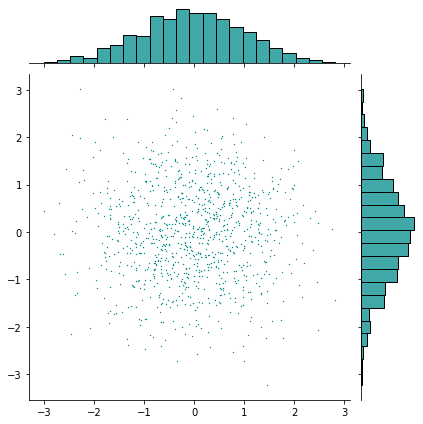

In [6]:
x1 = np.random.normal(loc=0, scale=1, size = 1000)
y1 = np.random.normal(loc=0, scale = 1, size=1000)
sns.jointplot(x=x1, y= y1, kind = 'scatter', color = 'darkcyan', s = 2 )
M_covarianza1 = np.cov(x1, y1)
print(M_covarianza1.round(2))
plt.show()

[[ 1.37 -2.7 ]
 [-2.7   6.4 ]]


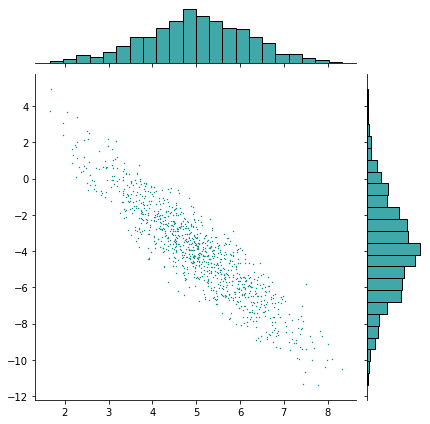

In [7]:
x2  = np.random.normal(loc=5, scale=1.2, size = 1000)
y2 = 6 - 2*x2 + np.random.normal(size=1000)
sns.jointplot(x=x2, y= y2, kind = 'scatter', color = 'darkcyan', s = 2 )
M_covarianza2 = np.cov(x2, y2)
print(M_covarianza2.round(2))
plt.show()

podríamos generar las coordenadas de puntos aleatoiros por medio de la distribución normal multivariada, ingresando las medias y la matriz de covarianza

In [8]:
medias = np.array((x2.mean(), y2.mean()))
medias.shape, M_covarianza2.shape

((2,), (2, 2))

In [9]:
coordenadas = np.random.multivariate_normal(mean = medias, cov = M_covarianza2, size = 1000)
coordenadas.shape

(1000, 2)

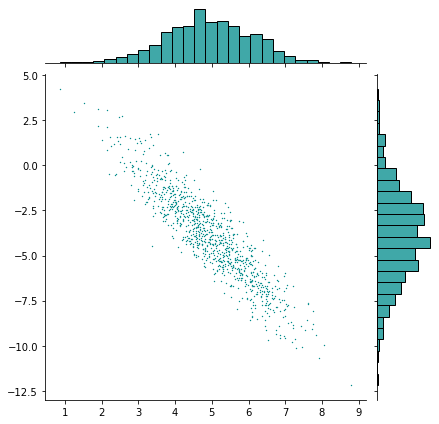

In [10]:
sns.jointplot(x=coordenadas[:,0], y=coordenadas[:,1], kind = 'scatter', color = 'darkcyan', s = 2 )
plt.show()

# Estimacion de la probabilidad de conflicto entre dos aviones
Dos aviones se consideran en conflicto cuando la distancia entre ellos es menor al umbral de 0.1 nmi en algun punto de sus trayectorias.

## 1) Simulación de trayectorias de vuelo
La estimación de probabilidad de conflicto se calcua para trayectorias de 20 min
La trayectoria de cada vuelo se define en el tiempo mediante dos coordenadas $Xa$ y $Xc$


![image.png](https://drive.google.com/uc?id=1KetZH3OEStTkAYjZEtjLJeEY__dMPoEH)

$x_t = (x_{a,t}, x_{c,t})$

$x_{a,t} = vt + error_{a,t}~~~~$  (Along-track component)

$x_{c,t} = error_{c,t}~~~~~~~~~~~~~$       (Cross-track component)


Se simularán coordenadas de cada avion en intervalos regulares de un minuto

### 1.1) Partimos de la Matriz de Covarianza de los errores en el tiempo
**Tanto para el componente along-track, como para el cors-track.**





$\mathbb{Cov}(error_{a,t},~error_{a,s}) = r_a^2t^2$

$\mathbb{Cov}(error_{c,t},~error_{c,s}) = \sigma_c^2(1-e^{-2\frac{r_c}{\sigma_c}vt})e^{-\frac{r_c}{\sigma_c}v(s-t)}$


---
R. A. Paielli y H. Erzberger, «Conflict Probability Estimation for Free Flight», Journal of Guidance, Control, and Dynamics, may 2012, doi: 10.2514/2.4081.


In [11]:
v = 8           # velocidad (nmi/min)(nmi -> millas naúticas)

# Para aviones con turvina civil se tiene
r_c = 1/57      #  nmi/min 
sigma_c = 1     #  nmi

r_a = 0         # se omiten los errores along-track

# CÁLCULO DE COVARIANZAS
cov_c = covarianza_c(sigma_c, r_c, v)
cov_a = covarianza_a(r_a)

In [12]:
cov_c

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.244746,0.212698,0.184846,0.160641,0.139605,0.121324,0.105437,0.091631,0.079632,0.069204,0.060142,0.052267,0.045423,0.039475,0.034306,0.029813,0.025909,0.022517,0.019568,0.017006
2,0.0,0.212698,0.429592,0.373338,0.324451,0.281965,0.245043,0.212955,0.185069,0.160835,0.139774,0.121471,0.105565,0.091742,0.079728,0.069288,0.060215,0.052330,0.045478,0.039523,0.034347
3,0.0,0.184846,0.373338,0.569197,0.494663,0.429888,0.373596,0.324675,0.282160,0.245212,0.213102,0.185197,0.160946,0.139871,0.121555,0.105638,0.091805,0.079783,0.069336,0.060257,0.052366
4,0.0,0.160641,0.324451,0.494663,0.674635,0.586294,0.509520,0.442800,0.384817,0.334426,0.290634,0.252577,0.219503,0.190760,0.165780,0.144072,0.125206,0.108811,0.094562,0.082180,0.071419
5,0.0,0.139605,0.281965,0.429888,0.586294,0.754267,0.655498,0.569663,0.495067,0.430240,0.373901,0.324940,0.282390,0.245412,0.213276,0.185348,0.161078,0.139985,0.121654,0.105724,0.091880
6,0.0,0.121324,0.245043,0.373596,0.509520,0.655498,0.814409,0.707765,0.615085,0.534542,0.464545,0.403715,0.350850,0.304907,0.264980,0.230282,0.200127,0.173921,0.151147,0.131355,0.114154
7,0.0,0.105437,0.212955,0.324675,0.442800,0.569663,0.707765,0.859832,0.747240,0.649391,0.564355,0.490455,0.426231,0.370418,0.321913,0.279759,0.243126,0.211289,0.183622,0.159577,0.138681
8,0.0,0.091631,0.185069,0.282160,0.384817,0.495067,0.615085,0.747240,0.894137,0.777053,0.675301,0.586872,0.510023,0.443237,0.385197,0.334757,0.290921,0.252826,0.219719,0.190948,0.165944
9,0.0,0.079632,0.160835,0.245212,0.334426,0.430240,0.534542,0.649391,0.777053,0.920047,0.799570,0.694869,0.603878,0.524802,0.456081,0.396359,0.344457,0.299351,0.260152,0.226086,0.196481


### 1.2) Simulación de errores y calculo de coordenadas Along-Track y Cross-Track

In [13]:
d = 2            # distancia entre trayectorias
n = 100          # número de simulaciones

X_a = {}    # diccionario para guardar las cordenadas Along-Track de cada aeronave
X_c = {}    # diccionario para guardar las coordenadas Cross-Track de cada aeronave

for aeronave, signo_posicion in zip(['A','B'], (1,-1)):

    # SIMULACIÖN DE LOS ERRORES

    error_c = simulacion_error(cov_c, n_simulaciones = n)
    error_a = simulacion_error(cov_a, n_simulaciones = n)

    # CÁLCULO DE LAS COORDENADAS Along-Track (X_a = v_por_t + error)

    # Obtenemos v * t para cada t
    v_por_t = pd.Series( v * np.arange(21), 
                        index=['min_' + str(t) for t in range(21)])
    
    X_a[aeronave] = v_por_t + error_a

    # CÁLCULO DE COORDENADAS Cross-Track(

    X_c[aeronave] = error_c +( d/2 * signo_posicion)  

In [14]:
X_c['A']

,min_0,min_1,min_2,min_3,min_4,min_5,min_6,min_7,min_8,min_9,min_10,min_11,min_12,min_13,min_14,min_15,min_16,min_17,min_18,min_19,min_20
simulación_1,1.0,1.236908,1.088578,2.083925,3.115974,2.422705,1.514169,2.041015,1.922317,1.875166,1.938061,1.214685,0.858825,0.748637,1.381664,1.201512,1.199317,0.761846,0.986967,0.536873,0.014524
simulación_2,1.0,1.452989,1.049262,1.449426,0.814686,0.300893,0.202508,-0.023288,-0.503431,-1.249655,-1.135468,-1.309587,-0.796653,0.080688,-0.585752,-0.021754,-0.307721,0.112053,-0.391580,-0.193047,-0.502405
simulación_3,1.0,0.499970,-0.041206,-0.698751,-0.371926,0.117651,0.504170,0.916788,0.528773,0.215731,0.253398,-0.475753,-0.680689,-0.852135,-2.646664,-2.351527,-2.163530,-1.343995,-1.182562,-1.550626,-2.156743
simulación_4,1.0,1.306118,0.666806,0.771927,0.752031,0.393188,0.497928,0.374793,0.122553,0.566520,0.341432,1.095275,1.413898,0.429623,1.144908,1.039825,0.371011,0.131547,0.182770,0.088956,-0.703964
simulación_5,1.0,0.804286,0.850364,0.900650,1.075181,1.303024,1.455330,1.206770,0.595116,1.386013,1.002661,0.845372,0.540741,0.186573,0.611341,0.317931,0.606603,0.705892,0.644696,1.057214,0.978914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
simulación_96,1.0,1.306601,0.950634,0.564274,0.186197,0.091409,0.028456,0.513013,0.208449,0.375025,0.429714,0.861118,0.764827,0.349997,0.923351,0.971526,1.056890,1.664142,1.408993,1.867052,2.188731
simulación_97,1.0,0.776469,0.977993,1.178279,1.151103,0.465780,1.435888,1.538958,1.414737,0.649297,0.621951,0.700126,0.020007,0.837833,0.445543,0.699515,0.270859,0.303911,1.296397,0.283573,1.491358
simulación_98,1.0,0.179350,0.848845,0.367317,1.209102,1.203106,-0.173433,-0.986693,-0.190846,0.047210,0.539899,0.461552,0.838306,0.117739,0.201244,0.719382,0.489984,0.017027,0.399048,0.853554,0.516537
simulación_99,1.0,0.149530,0.845670,0.709605,0.629019,-0.131834,-0.886447,-1.095005,-0.892376,-0.577788,-0.305167,-0.973166,-0.717548,-0.926330,0.333444,0.743690,0.362219,0.387341,0.787455,1.123576,0.208623


### VISUALIZACION DE TRAYECTORIAS

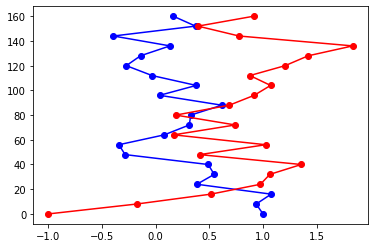

In [15]:
simulacion = 100
plt.plot(X_c['A'].loc['simulación_'+str(simulacion)].T, X_a['A'].loc['simulación_'+str(simulacion)].T, 'o-', color='b')
plt.plot(X_c['B'].loc['simulación_'+str(simulacion)].T, X_a['B'].loc['simulación_'+str(simulacion)].T, 'o-', color='r')
plt.show()

## 2) Estimación de la probabilidad de conflicto
La estimación de probabilidad de conflicto se calcua para trayectorias de 20 min
La trayectoria de cada vuelo se define en el tiempo mediante dos coordenadas $Xa$ y $Xc$


In [16]:
a = 0.1
Z = np.min((X_c['A']-X_c['B'])**2+(X_a['A']-X_a['B'])**2, axis=1)<a**2
p = Z.mean()
varianza = p*(1-p)
error = 2*((p*(1-p)/n)**0.5)

print('Probabilidad ={},\nVarianza ={},\nError ={}'.format(p, varianza, error))

Probabilidad =0.25,
Varianza =0.1875,
Error =0.08660254037844387


In [17]:
def intervalo_confianza_bernoulli(tam_muestra, p_muestra , nivel_confianza):
  '''p es la probabilidad obtenida en la muestra
     nivel de confianza debe estar entre 0 y 1'''
  izq = (1 - nivel_confianza)/2
  z_score = - stats.norm.ppf(izq)
  margen_error = z_score/(2*math.sqrt(tam_muestra))
  v_inf = p_muestra - margen_error
  v_sup = p_muestra + margen_error
  print('Con probabilidad de 95% la probabilidad de colición está en el intervalo:',
        v_inf, v_sup)
  return margen_error

In [18]:
intervalo_confianza_bernoulli(n, p, 0.95)

Con probabilidad de 95% la probabilidad de colición está en el intervalo: 0.1520018007729973 0.3479981992270027


0.0979981992270027

$\epsilon \leq \cfrac{z_{score}}{2\sqrt{n}}$

$n = \cfrac{{z_{score}}^2}{4\epsilon^2}$

$n = \cfrac{{1.96}^2}{4\epsilon^2}$

In [28]:
(1.96**2)/(4*(0.01**2))

9603.999999999998

## TODO JUNTO

In [29]:
n = 10000          # número de simulaciones
p, varianza, error, Z = probabilidad_de_conflicto(velocidad = v, distancia=d,
                                                  r_a=r_a, r_c=r_c, sigma_c=sigma_c,
                                                  n_simulaciones = n)
print('Probabilidad = {},\nVarianza = {},\nError = {}'.format(p, varianza, error))

Probabilidad = 0.2467,
Varianza = 0.18547008004924,
Error = 0.008613247472335623


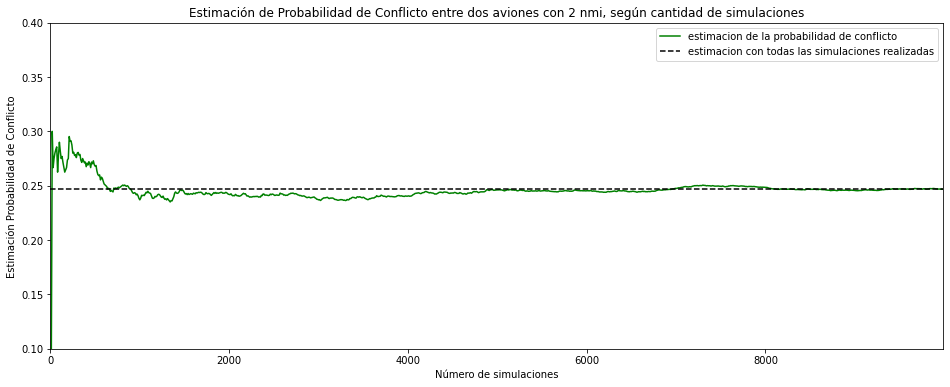

In [31]:
ns =range(0,10000,10)
estimacion_p = []
for n in ns:
  estimacion_p.append(Z[:n].mean())

#Gráfica estimación de p
plt.figure(figsize=(16, 6))
plt.plot(ns, estimacion_p, color='g', label = 'estimacion de la probabilidad de conflicto')
plt.axhline(y=p, color='black', ls='--', label='estimacion con todas las simulaciones realizadas')
plt.xlim(0, ns[-1])
plt.ylim(.1, .4)
plt.xlabel('Número de simulaciones')
plt.ylabel('Estimación Probabilidad de Conflicto')
plt.title('Estimación de Probabilidad de Conflicto entre dos aviones con {} nmi, según cantidad de simulaciones'.format(d))
plt.legend()
plt.show()

# Probabilidad de conflicto en función de la distancia entre aviones

In [32]:
n = 10000      # número de simulaciones
distancias =  np.arange(0.2,5,0.2)          
probabilidad =[]

for dist in distancias:
  resultados = probabilidad_de_conflicto(velocidad = v, distancia=dist,
                                         r_a=r_a, r_c=r_c, sigma_c=sigma_c,
                                         n_simulaciones = n)
  probabilidad.append(resultados[0])

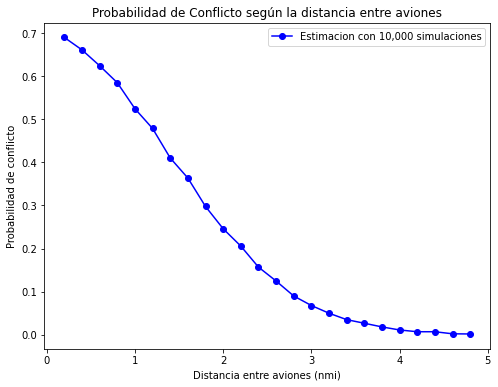

In [33]:
#Gráfica estimación de p
plt.figure(figsize=(8, 6))
plt.plot(distancias, probabilidad, 'o-', color='b', label ='Estimacion con {:,d} simulaciones'.format(n))
plt.xlabel('Distancia entre aviones (nmi)')
plt.ylabel('Probabilidad de conflicto')
plt.title('Probabilidad de Conflicto según la distancia entre aviones')
plt.legend()
plt.show()

#MCMC

In [ ]:
#MCMC


sigma_c=1
r_c=1/57
v=8
r_a = 0.25
m=np.zeros(20)
covA=np.zeros((20,20))
covC=np.zeros((20,20))
for s in range(20):
    covC[s,s]=(sigma_c**2)*(1-np.exp(-2*r_c*v*(s+1)/sigma_c))
    covA[s,s]=(r_a**2)*((s+1)**2)
    for t in range(s):
        covC[t,s]=covC[s,t]=(sigma_c**2)*(1-np.exp(-2*r_c*v*(t+1)/sigma_c))*np.exp(-r_c*v*(s-t)/sigma_c)
        covA[t,s]=covA[s,t]=(r_a**2)*((t+1)**2)
        
        
    

In [ ]:
 
def NiveauxSplitting2(a, seuil, rho, rho_bar, n,d):

   
    mu1=np.zeros(20)+d/2
    
    XA = np.random.multivariate_normal(np.zeros(20), 2*covA,size=1)
    XC = np.random.multivariate_normal(2*mu1, 2*covC,size=1)
    X=np.concatenate((XA, XC), axis=1)

    YA = np.random.multivariate_normal(np.zeros(20), 2*covA,size=n)
    YC = np.random.multivariate_normal(2*mu1, 2*covC,size=n)
    Y=np.concatenate((YA, YC), axis=1)
   
    for i in range(n):
        XC = np.append(XC, rho*(XC[-1:,]-2*mu1) + rho_bar*(YC[i,:]-2*mu1)+2*mu1,axis=0)
        XA = np.append(XA, rho*(XA[-1:,]) + rho_bar*(YA[i,:]),axis=0)
        X=np.concatenate((XA, XC), axis=1)
       
    X=np.array(sorted(list(X),key=lambda x:min(x[:20]*x[:20]+x[20:]*x[20:])))
    
    quantiles = np.array([])    
    
    b=np.sqrt(np.min((X[int(np.ceil((1-seuil)*n)-1)][:20]*X[int(np.ceil((1-seuil)*n)-1)][:20]+X[int(np.ceil((1-seuil)*n)-1)][20:]*X[int(np.ceil((1-seuil)*n)-1)][20:])))
    quantiles = np.append(quantiles,np.sqrt(np.min((X[int(np.ceil((1-seuil)*n)-1)][:20]*X[int(np.ceil((1-seuil)*n)-1)][:20]+X[int(np.ceil((1-seuil)*n)-1)][20:]*X[int(np.ceil((1-seuil)*n)-1)][20:]))  ))
    #print(quantiles)
    while (quantiles[-1] > a ):
        
        ## On recupere la premiere valeur de la chaine
        ## precedente qui est inferieur au quantile:
        ## pour initialiser la chaine courante 
        startingPoint = (X[np.sqrt(np.amin(X[:,:20]*X[:,:20]+X[:,20:]*X[:,20:],axis=1)) <= quantiles[-1]][0])

        X = np.array([startingPoint])
        XA=X[:,:20]
        XC=X[:,20:]
        ## Simulation du processus AR(1) conditionnel
        YA = np.random.multivariate_normal(np.zeros(20), 2*covA,size=n)
        YC = np.random.multivariate_normal(2*mu1, 2*covC,size=n)
        Y=np.concatenate((YA, YC), axis=1)
        for i in range(n):
            
           
        
            newXA=rho*(XA[-1:,]) + rho_bar*(YA[i,:])
            newXC= rho*(XC[-1:,]-2*mu1) + rho_bar*(YC[i,:]-2*mu1)+2*mu1
            alpha=np.sqrt(np.amin(newXA*newXA+newXC*newXC))
            XC = np.append(XC, newXC*(alpha <=quantiles[-1] )+X[-1:,20:]*(alpha >quantiles[-1] ),axis=0)
            XA = np.append(XA, newXA*(alpha <=quantiles[-1] )+X[-1:,:20]*(alpha >quantiles[-1] ),axis=0)
            
            X=np.concatenate((XA, XC), axis=1)


        X=np.array(sorted(list(X),key=lambda x:min(x[:20]*x[:20]+x[20:]*x[20:])))

        quantiles = np.append(quantiles, np.sqrt(np.min((X[int(np.ceil((1-seuil)*n)-1)][:20]*X[int(np.ceil((1-seuil)*n)-1)][:20]+X[int(np.ceil((1-seuil)*n)-1)][20:]*X[int(np.ceil((1-seuil)*n)-1)][20:])) ))
          
    
         
        
        
    ## On selectionne les niveaux a_1, a_2,... strictement en dessous de a
    
    quantiles = quantiles[:-1]
    ## On rajoute a
    
    quantiles = np.append(quantiles, a)
    
    
    quantiles=list(dict.fromkeys(quantiles))
    
    #print(quantiles)
    return quantiles

In [ ]:

    
    
def probaAR(a, seuil, rho, rho_bar, n,d):       
    #n = 1000
    mu1=np.zeros(20)+d/2.
    niveaux = NiveauxSplitting2(a, seuil, rho, rho_bar, 500,d)

    ## Une fois les niveaux a_1, ..., a_k trouves, on lance
    ## la simulation des chaines pour estimer chaque probabilite
    ## conditionnelle, avec une valeur de n plus importante
   
    XA = np.random.multivariate_normal(np.zeros(20), 2*covA,size=1)
    XC = np.random.multivariate_normal(2*mu1, 2*covC,size=1)
    X=np.concatenate((XA, XC), axis=1)

    YA = np.random.multivariate_normal(np.zeros(20), 2*covA,size=n)
    YC = np.random.multivariate_normal(2*mu1, 2*covC,size=n)
    Y=np.concatenate((YA, YC), axis=1)
    ## Niveau 0: pas de rejet
    for i in range(n):
        XC = np.append(XC, rho*(XC[-1:,]-2*mu1) + rho_bar*(YC[i,:]-2*mu1)+2*mu1,axis=0)
        XA = np.append(XA, rho*(XA[-1:,]) + rho_bar*(YA[i,:]),axis=0)
        X=np.concatenate((XA, XC), axis=1)
    
    
    l=np.sqrt(np.amin(X[:,:20]*X[:,:20]+X[:,20:]*X[:,20:],axis=1))
   
    P = [ np.mean(l<=niveaux[0]) ]


    
    ## Niveau l
    k = len(niveaux)
    for l in range(1,k):
        ## On recupere la premiere valeur de la chaine precedente 
        ## qui est inferieure le niveau l-1:
        ## pour initialiser la chaine au niveau courant
        m=np.sqrt(np.amin(X[:,:20]*X[:,:20]+X[:,20:]*X[:,20:],axis=1))
        a_l_moins_1 = niveaux[(l-1)]
        count_true=sum(m <= a_l_moins_1)
        if(count_true>0):
          startingPoint = (X[m <= a_l_moins_1][0])
        else:
          X=np.array(sorted(list(X),key=lambda x:min(x[:20]*x[:20]+x[20:]*x[20:])))
          startingPoint = X[0]
       
        X=np.array([startingPoint]) 
        XA=X[:,:20]
        XC=X[:,20:]    
      
        YA = np.random.multivariate_normal(np.zeros(20), 2*covA,size=n)
        YC = np.random.multivariate_normal(2*mu1, 2*covC,size=n)
        Y=np.concatenate((YA, YC), axis=1)
        for i in range(n):
         
          newXA=rho*(XA[-1:,]) + rho_bar*(YA[i,:])
          newXC= rho*(XC[-1:,]-2*mu1) + rho_bar*(YC[i,:]-2*mu1)+2*mu1
          alpha=np.sqrt(np.amin(newXA*newXA+newXC*newXC))
          XC = np.append(XC, newXC*(alpha <=a_l_moins_1 )+X[-1:,20:]*(alpha >a_l_moins_1 ),axis=0)
          XA = np.append(XA, newXA*(alpha <=a_l_moins_1 )+X[-1:,:20]*(alpha >a_l_moins_1 ),axis=0)
          X=np.concatenate((XA, XC), axis=1)
        
        P.append( np.mean(np.sqrt(np.amin(X[:,:20]*X[:,:20]+X[:,20:]*X[:,20:],axis=1))<=niveaux[l]) )
    #Estimateur par methode de splitting
    Proba_emp_split =np.prod(P)

    return(Proba_emp_split)
    
   
   


In [ ]:
## Parametres du probleme
a = 0.1
seuil = 0.9
rho = 0.9

rho_bar = np.sqrt(1-rho**2)
d=8
n=1000
probaAR(a, seuil, rho, rho_bar, n,d)

1.0396198968564901e-11

In [ ]:
#on calcule l'erreur de notre estimation
a = 0.1
seuil = 0.92
rho = 0.9
rho_bar = np.sqrt(1-rho**2)
d=6
n=1500
l=[]
for i in range(10):
  l.append(probaAR(a, seuil, rho, rho_bar, n,d))

h=[np.mean(l),np.var(l),2*((np.var(l)/n)**0.5)]
print(h)

[9.775456151296296e-07, 2.490644648978839e-13, 2.5771532868542317e-08]
